In [1]:
#!pip3 install -q  neptune

In [2]:
import random
import torch
import numpy as np


def setup_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False, warn_only=True)
    torch.set_float32_matmul_precision("high")
    
SEED = 1000
setup_reproducibility(SEED)

In [201]:
from transformers import get_cosine_schedule_with_warmup
from scipy import signal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from huggingface_hub import login, snapshot_download
from tqdm.auto import tqdm



def cuda_to_np(tensor):
    return tensor.cpu().detach().numpy()


def get_scheduler(optimizer, train_dl, epochs):
    total_training_steps = len(train_dl) * epochs
    warmup_steps = int(total_training_steps * 0.05)  # e.g. 5% warmup
    
    return get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_training_steps
    )


def get_stats(tensor, p=True, r=False, minmax=False):
    if minmax:
        min, max = tensor.min(), tensor.max()
        mean, std = tensor.mean(), tensor.std()
        if p: print(f"Min: {min}, Max: {max} ,Mean: {mean}, Std: {std}")
        if r: return min, max, mean, std
    else:
        mean, std = tensor.mean(), tensor.std()
        if p: print(f"Mean: {mean}, Std: {std}")
        if r: return mean, std
    
    
def zscore(tensor, mean=None, std=None):
    if mean is None: mean = tensor.mean()
    if std is None: std = tensor.std()
    return (tensor - mean) / (std + 1e-8)


def get_model_size(model):
    print(sum(p.numel() for p in model.parameters()) / 1e6)
    

def get_index(iterable):
    return random.randint(0, len(iterable) - 1)


def get_indices(iterable, n):
    return random.sample(range(len(iterable)), n)


def split(inputs, targets, seed):
    return train_test_split(
        inputs,
        targets, 
        test_size=0.2,
        shuffle=True, 
        random_state=seed
    ) 


def show_waves(waves, dpi=100):
    """
    waves: numpy array of shape (3, N)
    Creates three separate figures that stretch wide.
    """
    N = waves.shape[1]
    t = np.arange(N)

    # Wide aspect ratio; height modest so each window fills width
    for i in range(waves.shape[0]):
        fig = plt.figure(figsize=(14, 4), dpi=dpi)  # wide figure
        ax = fig.add_subplot(111)
        ax.plot(t, waves[i], linewidth=1)
        ax.set_title(f"Wave {i+1}")
        ax.set_xlabel("Sample")
        ax.set_ylabel("Amplitude")
        ax.grid(True)
        fig.tight_layout()  # reduce margins to use width
        
    plt.show()
    
    
def hf_ds_download(hf_token, repo_id):
    login(hf_token[1:])
    return snapshot_download(repo_id, repo_type="dataset")


def get_spectra_features(X, b=False):
    """Create multi-channel features from spectra: raw, 1st derivative, 2nd derivative."""
    X_processed = np.zeros_like(X)
    # Baseline correction and SNV
    for i in tqdm(range(X.shape[0])):
        poly = np.polyfit(np.arange(X.shape[1]), X[i], 3)
        baseline = np.polyval(poly, np.arange(X.shape[1]))
        corrected_spec = X[i] - baseline
        #X_processed[i] = (corrected_spec - corrected_spec.mean()) / (corrected_spec.std() + 1e-8)
        X_processed[i] = corrected_spec
        
    # Calculate derivatives
    deriv1 = signal.savgol_filter(X_processed, window_length=11, polyorder=3, deriv=1, axis=1)
    deriv2 = signal.savgol_filter(X_processed, window_length=11, polyorder=3, deriv=2, axis=1)

    if b: return np.stack([X_processed, deriv1, deriv2], axis=1)
    return np.stack([deriv1, deriv2], axis=1)

In [4]:
import os

path = "/kaggle/input/dig-4-bio-raman-transfer-learning-challenge"
files = os.listdir(path)
[(i, files[i]) for i in range(len(files))]

[(0, 'sample_submission.csv'),
 (1, 'timegate.csv'),
 (2, 'mettler_toledo.csv'),
 (3, 'kaiser.csv'),
 (4, 'anton_532.csv'),
 (5, 'transfer_plate.csv'),
 (6, '96_samples.csv'),
 (7, 'tornado.csv'),
 (8, 'tec5.csv'),
 (9, 'metrohm.csv'),
 (10, 'anton_785.csv')]

In [19]:
import numpy as np
import pandas as pd


def load_transfer_data():
    csv_path = os.path.join(path, files[5])
    df = pd.read_csv(csv_path)

    input_cols = df.columns[1:2049]
    target_cols = df.columns[2050:]

    targets  = df[target_cols].dropna().to_numpy()

    df = df[input_cols]
    df['Unnamed: 1'] = df['Unnamed: 1'].str.replace("[\[\]]", "", regex=True).astype('int64')
    df['Unnamed: 2048'] = df['Unnamed: 2048'].str.replace("[\[\]]", "", regex=True).astype('int64')

    inputs = df.to_numpy().reshape(-1, 2, 2048)
    inputs = inputs.mean(axis=1)
    
    return inputs, targets


def preprocess_transfer_data():
    inputs, targets = load_transfer_data()
    
    spectra_selection = np.logical_and(
        300 <= np.array([float(one) for one in range(2048)]),
        np.array([float(one) for one in range(2048)]) <= 1942,
    )
    
    inputs = inputs[:, spectra_selection]
    
    wns = np.array([
        float(one) for one in range(2048)
    ])[spectra_selection]
    wavenumbers = np.arange(300, 1943)
    
    interpolated_data = np.array(
        [np.interp(wavenumbers, xp=wns, fp=i) for i in inputs]
    )
    
    normed_spectra = interpolated_data / np.max(interpolated_data)
    return normed_spectra, targets

In [5]:
import pandas as pd


lower_bounds = {
    'anton_532': 200,
    'anton_785': 100,
    'kaiser': -37,
    'mettler_toledo': 300,
    'metrohm': 200,
    'tec5': 85,
    'timegate': 200,
    'tornado': 300,
}


upper_bounds = {
    'anton_532': 3500,
    'anton_785': 2300,
    'kaiser': 1942,
    'mettler_toledo': 3350,
    'metrohm': 3350,
    'tec5': 3210,
    'timegate': 2000,
    'tornado': 3300,
}

def get_dataset(name, lower=-1000, upper=10000):
    path = "/kaggle/input/dig-4-bio-raman-transfer-learning-challenge"
    df = pd.read_csv(os.path.join(path, name))

    lower = max(lower, lower_bounds[name[:-4]])
    upper = min(upper, upper_bounds[name[:-4]])

    spectra_selection = np.logical_and(
        lower <= np.array([float(one) for one in df.columns[:-5]]),
        np.array([float(one) for one in df.columns[:-5]]) <= upper,
    )
    
    spectra = df.iloc[:, :-5].iloc[:, spectra_selection].values
    label = df.iloc[:, -5:-2].values

    wavenumbers = np.array([
        float(one) for one in df.columns[:-5]
    ])[spectra_selection]

    #indices = get_indices(spectra, num_samples)                         
    return spectra, label, wavenumbers


def load_datasets(ds_names, lower=-1000, upper=10000):
        
    lower = max(
        lower,
        *[lower_bounds[n[:-4]] for n in ds_names])
    
    upper = min(
        upper,
        *[upper_bounds[n[:-4]] for n in ds_names]
    )

    datasets = [get_dataset(name, lower, upper) for name in ds_names]
    wavenumbers = np.arange(lower, upper + 1)

    interpolated_data = [
        np.array([
            np.interp(
                wavenumbers,
                xp=wns,
                fp=spectrum,
            )
            for spectrum in spectra
        ])
        for spectra, _, wns in datasets
    ]

    normed_spectra = np.concatenate(
        [
            spectra / np.max(spectra)
            for spectra in interpolated_data
        ],
        axis=0,
    )

    labels = np.concatenate([ds[1] for ds in datasets])
    return normed_spectra, labels

ds_names = ["anton_532.csv", "anton_785.csv", "kaiser.csv", "mettler_toledo.csv", "metrohm.csv", "tornado.csv", "tec5.csv", "timegate.csv"]
inputs, targets = load_datasets(ds_names)

In [238]:
import random
import torch
from torch.utils.data import Dataset
import scipy.optimize


np_dtype_from_torch = {
    torch.float32: np.float32,
    torch.float64: np.float64,
}

class SpectralDataset(Dataset):
    def __init__(
        self,
        spectra,
        concentrations,
        dtype=None,
        spectra_mean_std=None,
        concentration_mean_std=None,
        combine_spectra_range=0.0,
        baseline_factor_bound=0.0,
        baseline_period_lower_bound=100.0,
        baseline_period_upper_bound=200.0,
        augment_slope_std=0.0,
        augment_intersept_std=0.0,
        rolling_bound=0,
        spectrum_rolling_sigma=0.0,
        augmentation_weight=0.1,
        original_datapoint_weight=1.,
    ):
        self.dtype = dtype or torch.float32
        self.combine_spectra_range = combine_spectra_range
        self.baseline_factor_bound = baseline_factor_bound
        self.augment_slope_std = augment_slope_std
        self.augment_intercept_std = augment_intersept_std
        self.baseline_period_lower_bound = baseline_period_lower_bound
        self.baseline_period_upper_bound = baseline_period_upper_bound
        self.rolling_bound = rolling_bound
        self.spectrum_rolling_sigma = spectrum_rolling_sigma
        self.augmentation_weight = torch.tensor(augmentation_weight, dtype=dtype)
        self.original_dp_weight = original_datapoint_weight

        # normalize spectra
        spectra = torch.tensor(spectra, dtype=dtype)

        if spectra_mean_std is None:
            self.s_mean = torch.mean(spectra)
            self.s_std = torch.std(spectra)
        else:
            self.s_mean, self.s_std = spectra_mean_std

        self.spectra = torch.divide(
            torch.subtract(spectra, self.s_mean),
            self.s_std,
        )

        self.dummy_wns = np.tile(
            np.arange(
                0., 1., 1. / self.spectra.shape[2],
                dtype=np_dtype_from_torch[self.dtype]
            )[None, :self.spectra.shape[2]],
            (self.spectra.shape[1], 1),
        )

        # normalize concentrations
        concentrations = torch.tensor(concentrations, dtype=dtype)
        if concentration_mean_std is None:
            self.concentration_means = torch.nanmean(concentrations, dim=0)

            self.concentration_stds = torch.maximum(
                torch.tensor(
                    [
                        torch.std(col[torch.logical_not(torch.isnan(col))])
                        for col in concentrations.T
                    ]
                ),
                torch.tensor([1e-3] * concentrations.shape[1]),
            )
        else:
            self.concentration_means = concentration_mean_std[0]
            self.concentration_stds = concentration_mean_std[1]

        self.concentrations = torch.divide(
            torch.subtract(
                concentrations,
                self.concentration_means,
            ),
            self.concentration_stds,
        )

    def pick_two(self, max_idx=None):
        max_idx = max_idx or len(self)
        return random.choices(range(max_idx), k=2)

    def __len__(self):
        return len(self.concentrations)

    def augment_spectra(self, spectra):
        if self.augment_slope_std > 0.0:

            def spectrum_approximation(x, slope, intercept):
                return (slope * x + intercept).reshape(-1, 1)[:, 0]

            slope, inter = scipy.optimize.curve_fit(
                spectrum_approximation,
                self.dummy_wns,
                spectra.reshape(-1, 1)[:, 0],
                p0=np.random.rand(2),
            )[0]

            new_slope = slope * (
                    np.random.gamma(
                        shape=1. / self.augment_slope_std,
                        scale=self.augment_slope_std,
                        size=1,
                    )
            )[0]
            new_intercept = inter * (
                1.0 + np.random.randn(1) * self.augment_intercept_std
            )[0]
            spectra += torch.tensor(
                (new_slope - slope)
            ) * self.dummy_wns + new_intercept - inter

        factor = self.baseline_factor_bound * torch.rand(size=(1,))
        offset = torch.rand(size=(1,)) * 2.0 * torch.pi
        period = self.baseline_period_lower_bound + (
            self.baseline_period_upper_bound - self.baseline_period_lower_bound
        ) * torch.rand(size=(1,))
        permutations = factor * torch.cos(
            2.0 * torch.pi / period * self.dummy_wns + offset
        )
        return self.roll_spectrum(
            spectra + permutations * spectra,
            delta=random.randint(-self.rolling_bound, self.rolling_bound),
        )

    def roll_spectrum(self, spectra, delta):
        num_spectra = spectra.shape[0]
        rolled_spectra = np.roll(spectra, delta, axis=1)
        if delta > 0:
            rolled_spectra[:, :delta] = (
                np.random.rand(num_spectra, delta) * self.spectrum_rolling_sigma + 1
            ) * rolled_spectra[:, delta:(delta + 1)]
        elif delta < 0:
            rolled_spectra[:, delta:] = (
                np.random.rand(num_spectra, -delta) * self.spectrum_rolling_sigma + 1
            ) * rolled_spectra[:, delta - 1:delta]
        return rolled_spectra

    def combine_k_items(self, indices, weights):
        return (
            # spectra
            torch.sum(
                torch.mul(weights[:, None, None], self.spectra[indices, :, :]),
                dim=0,
            ),
            # concentrations
            torch.sum(
                torch.mul(weights[:, None], self.concentrations[indices, :]),
                dim=0,
            )
        )

    def __getitem__(self, idx):
        if self.combine_spectra_range < 1e-12:
            spectrum = self.spectra[idx]
            spectrum = self.augment_spectra(spectrum)
            return {
                "spectra": spectrum,
                "concentrations": self.concentrations[idx],
                "label_weight": torch.tensor(1.0, dtype=self.dtype),
            }
        else:
            if random.random() < self.original_dp_weight:
                one_weight = 1.
                label_weight = torch.tensor(1.0, dtype=self.dtype)
            else:
                one_weight = random.uniform(0.0, self.combine_spectra_range)
                label_weight = self.augmentation_weight
            weights = torch.tensor([one_weight, (1 - one_weight)])
            # just pick two random indices
            indices = random.choices(range(len(self)), k=2)

            mixed_spectra, mixed_concentrations = self.combine_k_items(
                indices=indices,
                weights=weights,
            )
            mixed_spectra = self.augment_spectra(mixed_spectra)
            return mixed_spectra, mixed_concentrations, label_weight


config = {
    'initial_cnn_channels': 32,
    'cnn_channel_factor': 1.279574024454846,
    'num_cnn_layers': 8,
    'kernel_size': 3,
    'stride': 2,
    'activation_function': 'ELU',
    'fc_dropout': 0.10361700399831791,
    'lr': 0.001,
    'gamma': 0.9649606352621118,
    'baseline_factor_bound': 0.748262317340447,
    'baseline_period_lower_bound': 0.9703081695287203,
    'baseline_period_span': 19.79744237606427,
    'original_datapoint_weight': 0.4335003268130408,
    'augment_slope_std': 0.08171025264382692,
    'batch_size': 32,
    'fc_dims': 226,
    'rolling_bound': 2,
    'num_blocks': 2,
}

def get_dataset(inputs, targets, config, inputs_mean_std=None, targets_mean_std=None):
    return SpectralDataset(
        spectra=inputs[:, None, :],
        concentrations=targets,
        dtype=torch.float32,
        spectra_mean_std=inputs_mean_std,
        concentration_mean_std=targets_mean_std,
        combine_spectra_range=1.0,
        baseline_factor_bound=config["baseline_factor_bound"],
        baseline_period_lower_bound=config["baseline_period_lower_bound"],
        baseline_period_upper_bound=(config["baseline_period_lower_bound"] + config["baseline_period_span"]),
        augment_slope_std=config["augment_slope_std"],
        augment_intersept_std=0.0,
        rolling_bound=config["rolling_bound"],
        spectrum_rolling_sigma=0.01,
        augmentation_weight=0.1,
        original_datapoint_weight=1.,
    )

In [7]:
from torch.utils.data import DataLoader


def build_loader(
    SEED,
    ds,
    train=True,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    drop_last=True,
    pin_memory=True,
    persistent_workers=False,
):
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    generator = torch.Generator()
    generator.manual_seed(SEED if train else SEED+5232)

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=drop_last,
        persistent_workers=persistent_workers,
        worker_init_fn=seed_worker,
        generator=generator,
        #sampler=DistributedSampler(
        #    train_ds,
        #    shuffle=True,
        #    drop_last=True,
        #    seed=config.seed
        #)
    )
    
    
def return_dls(train_ds, eval_ds, train_batch_size, eval_batch_size):
    train_dl = build_loader(
        SEED,
        train_ds,
        train=True,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=0,
        drop_last=False,
        pin_memory=True,
        persistent_workers=False,
    )

    eval_dl = build_loader(
        SEED,
        eval_ds,
        train=False,
        batch_size=eval_batch_size,
        shuffle=False,
        num_workers=0,
        drop_last=False,
        pin_memory=True,
        persistent_workers=False,
    )
    
    return train_dl, eval_dl

In [8]:
import neptune


def setup_neptune():
    if not RESUME:
        neptune_run = neptune.init_run(
            project="arbaaz/kaggle-spect",
            name=MODEL_NAME,
            api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlOGE2YjNiZS1mZGUyLTRjYjItYTg5Yy1mZWJkZTIzNzE1NmIifQ=="
        )

        neptune_run["h_parameters"] = {
            "seed": SEED,
            "model_name": MODEL_NAME,
            "optimizer_name": "nadam",
            "learning_rate": LR,
            "scheduler_name": "default",
            "weight_decay": WD,
            "num_epochs": EPOCHS,
            "batch_size": BATCH_SIZE,
        }
        if DROPOUT: neptune_run["h_parameters"] = {"dropout": DROPOUT}
        if DROP_PATH_RATE: neptune_run["h_parameters"] = {"drop_path_rate": DROP_PATH_RATE}
    else:
        neptune_run = neptune.init_run(
            project="arbaaz/crunchdao-structural-break",
            with_id=config.with_id,
            api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlOGE2YjNiZS1mZGUyLTRjYjItYTg5Yy1mZWJkZTIzNzE1NmIifQ=="
        )

    return neptune_run

In [9]:
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
from sklearn.metrics import r2_score


def loss_fn(logits, targets):
    logits = logits.view(-1)
    targets = targets.view(-1)
    return F.mse_loss(logits, targets)


def metric_fn(logits, targets):
    preds = logits.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    
    dim1 = r2_score(targets[:, 0], preds[:, 0])
    dim2 = r2_score(targets[:, 1], preds[:, 1])
    dim3 = r2_score(targets[:, 2], preds[:, 2])
    
    return dim1, dim2, dim3, r2_score(targets, logits)


class MSEIgnoreNans(_Loss):
    def forward(
        self,
        input: torch.Tensor,
        target: torch.Tensor,
        weights: torch.Tensor,
    ) -> torch.Tensor:
        mask = torch.isfinite(target)
        mse = torch.mean(
            torch.mul(
                torch.square(input[mask] - target[mask]),
                torch.tile(weights[:, None], dims=(1, target.shape[1]))[mask],
            )
        )
        return torch.where(
            torch.isfinite(mse),
            mse,
            torch.tensor(0.).to(target.device),
        )

In [10]:
import torch.nn as nn


class ResidualBlock(nn.Module):
    """A residual block with two 1D convolutional layers."""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.elu = nn.ELU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.elu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.elu(out)
        return out
    

class ResNet(nn.Module):
    """A deeper ResNet-style 1D CNN for Raman spectra."""
    def __init__(self, dropout, input_channels=3, num_classes=3):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.elu = nn.GELU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ELU(),
            nn.Dropout(dropout), # Increased dropout for better regularization
            nn.Linear(256, num_classes)
        )

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride=s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.elu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [11]:
import math


class Identity(torch.torch.nn.Module):
    def forward(self, x):
        return x


# this is not a resnet yet
class ReZeroBlock(torch.torch.nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        activation_function,
        kernel_size,
        stride,
        dtype,
        norm_layer=None,
    ):
        super(ReZeroBlock, self).__init__()
        if norm_layer is None:
            norm_layer = torch.torch.nn.BatchNorm1d

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = divmod(kernel_size, 2)[0] if stride == 1 else 0

        # does not change spatial dimension
        self.conv1 = torch.nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=1,
            stride=1,
            bias=False,
            dtype=dtype,
        )
        self.bn1 = norm_layer(out_channels, dtype=dtype)
        # Both self.conv2 and self.downsample layers
        # downsample the input when stride != 1
        self.conv2 = torch.nn.Conv1d(
            out_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            groups=out_channels,
            bias=False,
            dtype=dtype,
            padding=self.padding,
        )
        if stride > 1:
            down_conv = torch.nn.Conv1d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                bias=False,
                dtype=dtype,
                # groups=out_channels,
            )
        else:
            down_conv = Identity()

        self.down_sample = torch.nn.Sequential(
            down_conv,
            norm_layer(out_channels),
        )
        self.bn2 = norm_layer(out_channels, dtype=dtype)
        # does not change the spatial dimension
        self.conv3 = torch.nn.Conv1d(
            out_channels,
            out_channels,
            kernel_size=1,
            stride=1,
            bias=False,
            dtype=dtype,
        )
        self.bn3 = norm_layer(out_channels, dtype=dtype)
        self.activation = activation_function(inplace=True)
        self.factor = torch.torch.nn.parameter.Parameter(torch.tensor(0.0, dtype=dtype))

    def next_spatial_dim(self, last_spatial_dim):
        return math.floor(
            (last_spatial_dim + 2 * self.padding - self.kernel_size)
            / self.stride + 1
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.activation(out)

        out = self.conv3(out)
        out = self.bn3(out)

        # not really the identity, but kind of
        identity = self.down_sample(x)

        return self.activation(out * self.factor + identity)


class ResNetEncoder(torch.torch.nn.Module):
    def __init__(
        self,
        spectrum_size,
        cnn_encoder_channel_dims,
        activation_function,
        kernel_size,
        stride,
        dtype,
        num_blocks,
        verbose=False,
    ):
        super(ResNetEncoder, self).__init__()

        self.spatial_dims = [spectrum_size]
        layers = []
        for in_channels, out_channels in zip(
            cnn_encoder_channel_dims[:-1],
            cnn_encoder_channel_dims[1:],
        ):
            block = ReZeroBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                activation_function=activation_function,
                kernel_size=kernel_size,
                stride=stride,
                dtype=dtype,
            )
            layers.append(block)
            self.spatial_dims.append(block.next_spatial_dim(self.spatial_dims[-1]))
            for _ in range(num_blocks - 1):
                block = ReZeroBlock(
                    in_channels=out_channels,
                    out_channels=out_channels,
                    activation_function=activation_function,
                    kernel_size=kernel_size,
                    stride=1,
                    dtype=dtype,
                )
                layers.append(block)
                self.spatial_dims.append(block.next_spatial_dim(self.spatial_dims[-1]))

        self.resnet_layers = torch.torch.nn.Sequential(*layers)
        if verbose:
            print("CNN Encoder Channel Dims: %s" % (cnn_encoder_channel_dims))
            print("CNN Encoder Spatial Dims: %s" % (self.spatial_dims))

    def forward(self, x):
        return self.resnet_layers(x)


class ReZeroNet(torch.nn.Module):
    def __init__(
        self,
        spectra_channels,
        spectra_size,
        initial_cnn_channels,
        cnn_channel_factor,
        num_cnn_layers,
        kernel_size,
        stride,
        activation_function,
        fc_dims,
        fc_dropout=0.0,
        dtype=None,
        verbose=False,
        fc_output_channels=1,
        num_blocks=1,
        **kwargs,
    ):
        super().__init__()
        self.fc_output_channels = fc_output_channels
        self.dtype = dtype or torch.float32

        activation_function = getattr(torch.nn, activation_function)

        # Setup CNN Encoder
        cnn_encoder_channel_dims = [spectra_channels] + [
            int(initial_cnn_channels * (cnn_channel_factor**idx))
            for idx in range(num_cnn_layers)
        ]
        self.cnn_encoder = ResNetEncoder(
            spectrum_size=spectra_size,
            cnn_encoder_channel_dims=cnn_encoder_channel_dims,
            activation_function=activation_function,
            kernel_size=kernel_size,
            stride=stride,
            num_blocks=num_blocks,
            dtype=dtype,
            verbose=verbose,
        )
        self.fc_dims = [
            int(
                self.cnn_encoder.spatial_dims[-1]
            ) * int(cnn_encoder_channel_dims[-1])
        ] + fc_dims

        if verbose:
            print("Fc Dims: %s" % self.fc_dims)
        fc_layers = []
        for idx, (in_dim, out_dim) in enumerate(
                zip(self.fc_dims[:-2], self.fc_dims[1:-1])
        ):
            fc_layers.append(torch.nn.Linear(in_dim, out_dim))
            fc_layers.append(torch.nn.ELU())
            fc_layers.append(torch.nn.Dropout(fc_dropout / (2 ** idx)))
        fc_layers.append(
            torch.nn.Linear(
                self.fc_dims[-2],
                self.fc_dims[-1] * self.fc_output_channels,
            ),
        )
        self.fc_net = torch.nn.Sequential(*fc_layers)
        if verbose:
            num_params = sum(p.numel() for p in self.parameters())
            print("Number of Parameters: %s" % num_params)

    def forward(self, spectra):
        embeddings = self.cnn_encoder(spectra)
        forecast = self.fc_net(embeddings.view(-1, self.fc_dims[0]))
        if self.fc_output_channels > 1:
            forecast = forecast.reshape(
                -1, self.fc_output_channels, self.fc_dims[-1]
            )
        return forecast


In [12]:
from tqdm.auto import tqdm


mse_loss_function = MSEIgnoreNans()

def train(
    model, 
    optimizer,
    device,
    scaler, 
    scheduler,
    train_dl,
    eval_dl,
    epochs,
    checkpoint_name,
    score=-float("inf"),
    neptune_run=None,
    p=True,
):  
    for epoch in tqdm(range(epochs)):
        model.train()
        total_loss = 0.0
        all_logits = []
        all_targets = []
        
        for inputs, targets, weights in train_dl:
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            weights = weights.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            with torch.amp.autocast(device_type=device, dtype=torch.float16, cache_enabled=True):
                logits = model(inputs)
                loss = mse_loss_function(logits, targets, weights)
            
            #loss.backward()
            #optimizer.step()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            if neptune_run is not None:  neptune_run["lr_step"].append(scheduler.get_last_lr()[0])
            
            total_loss += loss.detach().cpu()
            all_logits.append(logits.detach().cpu())
            all_targets.append(targets.detach().cpu())
        
        all_logits = torch.cat(all_logits)
        all_targets = torch.cat(all_targets)

        one, two, three, r2 = metric_fn(all_logits, all_targets)
        total_loss = total_loss / len(train_dl)
        
        model.eval()
        eval_total_loss = 0.0
        eval_all_logits = []
        eval_all_targets = []

        for inputs, targets, weights in eval_dl:
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            weights = weights.to(device, non_blocking=True)

            with torch.inference_mode():
                #with torch.amp.autocast(device_type=device, dtype=torch.float16, cache_enabled=True):
                logits = model(inputs)
                loss = mse_loss_function(logits, targets, weights)

            eval_total_loss += loss.detach().cpu()
            eval_all_logits.append(logits.detach().cpu())
            eval_all_targets.append(targets.detach().cpu())
        
        eval_all_logits = torch.cat(eval_all_logits)
        eval_all_targets = torch.cat(eval_all_targets)

        eval_one, eval_two, eval_three, eval_r2 = metric_fn(eval_all_logits, eval_all_targets)
        eval_total_loss = eval_total_loss / len(eval_dl)
        
        if eval_r2 > score:
            score = eval_r2
            data = {"state_dict": model.state_dict()}
            data["epoch"] = epoch 
            data["score"] = score
            torch.save(data, f"/kaggle/working/{checkpoint_name}")
        
        if neptune_run is not None:
            neptune_run["train/loss"].append(total_loss)
            neptune_run["eval/loss"].append(eval_total_loss)
            neptune_run["train/r2"].append(r2)
            neptune_run["eval/r2"].append(eval_r2)
            neptune_run["train/one"].append(one)
            neptune_run["train/two"].append(two)
            neptune_run["train/three"].append(three)
            neptune_run["eval/one"].append(eval_one)
            neptune_run["eval/two"].append(eval_two)
            neptune_run["eval/three"].append(eval_three)
            
        if p and epoch % 5 == 0:
            print(
                f"Epoch: {epoch}, "
                f"train/loss: {total_loss:.4f}, "
                f"eval/loss: {eval_total_loss:.4f}, "
                f"train/r2: {r2:.4f}, "
                f"eval/r2: {eval_r2:.4f}, "
                f"train/one: {one:.4f}, "
                f"train/two: {two:.4f}, "
                f"train/three: {three:.4f}, "
                f"eval/one: {eval_one:.4f}, "
                f"eval/two: {eval_two:.4f}, "
                f"eval/three: {eval_three:.4f} "
            )
            
    if neptune_run is not None: neptune_run.stop()
    return score

In [280]:
import warnings#; warnings.filterwarnings("ignore")


EPOCHS = 100
WD = 1e-3
LR = 1e-4

DROPOUT = 0.5
DROP_PATH_RATE = None

device = "cuda" if torch.cuda.is_available() else "cpu"
RESUME = False

config["dtype"] = torch.float32
config["spectra_size"] = 1643
config["spectra_channels"] = 1
config["fc_dims"] = [
    config["fc_dims"],
    int(config["fc_dims"] / 2),
    3,
]

#mse_loss_function = MSEIgnoreNans()

In [14]:
from sklearn.model_selection import KFold


inputs_mean_std = []
targets_mean_std = []
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
splits = kfold.split(inputs)

for fold, (train_idx, eval_idx) in enumerate(splits):
    MODEL_NAME = f"resnet.paper.pretrain.fold.{fold}"
    checkpoint_name = f"paper.pretrain.fold.{fold}.pt"
    
    train_inputs = inputs[train_idx]
    train_targets = targets[train_idx]
    eval_inputs = inputs[eval_idx]
    eval_targets = targets[eval_idx]

    train_ds = get_dataset(train_inputs, train_targets, config)
    
    inputs_mean_std.append((fold, train_ds.s_mean, train_ds.s_std))
    targets_mean_std.append((fold, train_ds.concentration_means, train_ds.concentration_stds))
    
    eval_ds = get_dataset(eval_inputs, eval_targets, config, (train_ds.s_mean, train_ds.s_std), (train_ds.concentration_means, train_ds.concentration_stds))
    
    BATCH_SIZE = 32
    train_dl, eval_dl = return_dls(train_ds, eval_ds, BATCH_SIZE, len(eval_ds))
    
    #model = ResNet(input_channels=1, dropout=DROPOUT).to(device)
    model = ReZeroNet(**config).to(device)
    if fold == 0: print(get_model_size(model))
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD, foreach=True)
    scaler = torch.amp.GradScaler(device)
    scheduler = get_scheduler(optimizer, train_dl, EPOCHS)
    
    score = train(
            model, 
            optimizer, 
            device,
            scaler,
            scheduler,
            train_dl, 
            eval_dl,
            EPOCHS,
            checkpoint_name,
            neptune_run=setup_neptune(),
        )
    
    scores.append(score)

0.734309
None


[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs-legacy.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/arbaaz/kaggle-spect/e/KAG-127


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, train/loss: 0.9485, eval/loss: 0.9172, train/r2: 0.0164, eval/r2: 0.0374, train/one: -0.0032, train/two: -0.0104, train/three: 0.0628, eval/one: -0.0054, eval/two: -0.0083, eval/three: 0.1261 
Epoch: 5, train/loss: 0.7194, eval/loss: 0.6305, train/r2: 0.2847, eval/r2: 0.3339, train/one: 0.0442, train/two: 0.1051, train/three: 0.7048, eval/one: 0.0660, eval/two: 0.1849, eval/three: 0.7507 
Epoch: 10, train/loss: 0.3866, eval/loss: 0.3250, train/r2: 0.5996, eval/r2: 0.6626, train/one: 0.3878, train/two: 0.5761, train/three: 0.8348, eval/one: 0.4975, eval/two: 0.6485, eval/three: 0.8418 
Epoch: 15, train/loss: 0.2743, eval/loss: 0.2452, train/r2: 0.7298, eval/r2: 0.7167, train/one: 0.6355, train/two: 0.6957, train/three: 0.8583, eval/one: 0.5665, eval/two: 0.6908, eval/three: 0.8929 
Epoch: 20, train/loss: 0.2079, eval/loss: 0.1980, train/r2: 0.7872, eval/r2: 0.7851, train/one: 0.7191, train/two: 0.7331, train/three: 0.9094, eval/one: 0.7077, eval/two: 0.7224, eval/three: 0.9252

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch: 0, train/loss: 0.9801, eval/loss: 0.9712, train/r2: 0.0044, eval/r2: 0.0276, train/one: -0.0115, train/two: -0.0134, train/three: 0.0382, eval/one: -0.0372, eval/two: -0.0060, eval/three: 0.1259 
Epoch: 5, train/loss: 0.6186, eval/loss: 0.6385, train/r2: 0.3776, eval/r2: 0.4178, train/one: 0.1911, train/two: 0.2410, train/three: 0.7008, eval/one: 0.1225, eval/two: 0.4116, eval/three: 0.7191 
Epoch: 10, train/loss: 0.3213, eval/loss: 0.3319, train/r2: 0.6855, eval/r2: 0.6543, train/one: 0.6013, train/two: 0.6288, train/three: 0.8264, eval/one: 0.4792, eval/two: 0.6280, eval/three: 0.8556 
Epoch: 15, train/loss: 0.2094, eval/loss: 0.2751, train/r2: 0.7899, eval/r2: 0.7340, train/one: 0.7323, train/two: 0.7476, train/three: 0.8899, eval/one: 0.6456, eval/two: 0.6651, eval/three: 0.8912 
Epoch: 20, train/loss: 0.1800, eval/loss: 0.2221, train/r2: 0.8102, eval/r2: 0.7725, train/one: 0.7703, train/two: 0.7608, train/three: 0.8996, eval/one: 0.6969, eval/two: 0.7440, eval/three: 0.8766

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, train/loss: 0.9731, eval/loss: 0.9186, train/r2: -0.0003, eval/r2: 0.0413, train/one: -0.0091, train/two: -0.0182, train/three: 0.0265, eval/one: 0.0093, eval/two: 0.0010, eval/three: 0.1134 
Epoch: 5, train/loss: 0.6867, eval/loss: 0.6917, train/r2: 0.3016, eval/r2: 0.3261, train/one: 0.0916, train/two: 0.1245, train/three: 0.6885, eval/one: 0.0830, eval/two: 0.1761, eval/three: 0.7193 
Epoch: 10, train/loss: 0.3572, eval/loss: 0.3772, train/r2: 0.6374, eval/r2: 0.6543, train/one: 0.4751, train/two: 0.6185, train/three: 0.8185, eval/one: 0.4722, eval/two: 0.6175, eval/three: 0.8733 
Epoch: 15, train/loss: 0.2439, eval/loss: 0.2885, train/r2: 0.7547, eval/r2: 0.7074, train/one: 0.6773, train/two: 0.7110, train/three: 0.8759, eval/one: 0.5584, eval/two: 0.6865, eval/three: 0.8774 
Epoch: 20, train/loss: 0.2118, eval/loss: 0.2727, train/r2: 0.7906, eval/r2: 0.7245, train/one: 0.7336, train/two: 0.7254, train/three: 0.9130, eval/one: 0.6441, eval/two: 0.6642, eval/three: 0.8651 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, train/loss: 0.9884, eval/loss: 0.9921, train/r2: -0.0009, eval/r2: 0.0352, train/one: -0.0268, train/two: -0.0172, train/three: 0.0412, eval/one: -0.0125, eval/two: -0.0266, eval/three: 0.1446 
Epoch: 5, train/loss: 0.7117, eval/loss: 0.6989, train/r2: 0.2906, eval/r2: 0.3076, train/one: 0.0632, train/two: 0.0909, train/three: 0.7177, eval/one: 0.0057, eval/two: 0.1660, eval/three: 0.7513 
Epoch: 10, train/loss: 0.3612, eval/loss: 0.3758, train/r2: 0.6264, eval/r2: 0.6535, train/one: 0.4707, train/two: 0.5871, train/three: 0.8215, eval/one: 0.5042, eval/two: 0.6380, eval/three: 0.8184 
Epoch: 15, train/loss: 0.2729, eval/loss: 0.2649, train/r2: 0.7259, eval/r2: 0.7257, train/one: 0.6281, train/two: 0.6851, train/three: 0.8646, eval/one: 0.6429, eval/two: 0.6574, eval/three: 0.8769 
Epoch: 20, train/loss: 0.2142, eval/loss: 0.3116, train/r2: 0.7827, eval/r2: 0.7111, train/one: 0.7130, train/two: 0.7362, train/three: 0.8989, eval/one: 0.6701, eval/two: 0.5961, eval/three: 0.867

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, train/loss: 0.9513, eval/loss: 0.9558, train/r2: 0.0387, eval/r2: 0.0342, train/one: -0.0082, train/two: -0.0114, train/three: 0.1356, eval/one: 0.0024, eval/two: -0.0633, eval/three: 0.1636 
Epoch: 5, train/loss: 0.7038, eval/loss: 0.7057, train/r2: 0.3068, eval/r2: 0.3097, train/one: 0.0730, train/two: 0.1576, train/three: 0.6897, eval/one: 0.0640, eval/two: 0.1777, eval/three: 0.6873 
Epoch: 10, train/loss: 0.3554, eval/loss: 0.2690, train/r2: 0.6365, eval/r2: 0.7240, train/one: 0.4766, train/two: 0.6132, train/three: 0.8198, eval/one: 0.6636, eval/two: 0.6769, eval/three: 0.8315 
Epoch: 15, train/loss: 0.2576, eval/loss: 0.2613, train/r2: 0.7410, eval/r2: 0.7462, train/one: 0.6463, train/two: 0.7176, train/three: 0.8590, eval/one: 0.6263, eval/two: 0.7286, eval/three: 0.8836 
Epoch: 20, train/loss: 0.2147, eval/loss: 0.2082, train/r2: 0.7829, eval/r2: 0.7863, train/one: 0.7234, train/two: 0.7387, train/three: 0.8865, eval/one: 0.7095, eval/two: 0.7403, eval/three: 0.9092 

In [277]:
output_dir = "/kaggle/working"
output_files = sorted(os.listdir(output_dir))

for f in output_files:
    if "paper.pretrain" in f:
        ckpt_path = os.path.join(output_dir, f)
        ckpt = torch.load(ckpt_path, weights_only=False)
        print(ckpt_path,  ckpt["epoch"], ckpt["score"])

/kaggle/working/paper.pretrain.fold.0.pt 91 0.8984074096794825
/kaggle/working/paper.pretrain.fold.1.pt 83 0.9005115171000501
/kaggle/working/paper.pretrain.fold.2.pt 94 0.8975027346781784
/kaggle/working/paper.pretrain.fold.3.pt 97 0.9116833694624038
/kaggle/working/paper.pretrain.fold.4.pt 92 0.9103507551328276


In [278]:
def get_ckpt(path):
    return torch.load(path, weights_only=False)

ckpt = get_ckpt("/kaggle/working/paper.pretrain.fold.3.pt")
ckpt["epoch"], ckpt["score"]

(97, 0.9116833694624038)

In [281]:
model = ReZeroNet(**config).to(device)
model.load_state_dict(ckpt["state_dict"])

<All keys matched successfully>

In [225]:
test_inputs, test_targets = preprocess_transfer_data()
test_inputs.shape, test_targets.shape

((96, 1643), (96, 3))

In [257]:
test_ds = get_dataset(test_inputs, test_targets, config, inputs_mean_std[3][1:], targets_mean_std[3][1:])

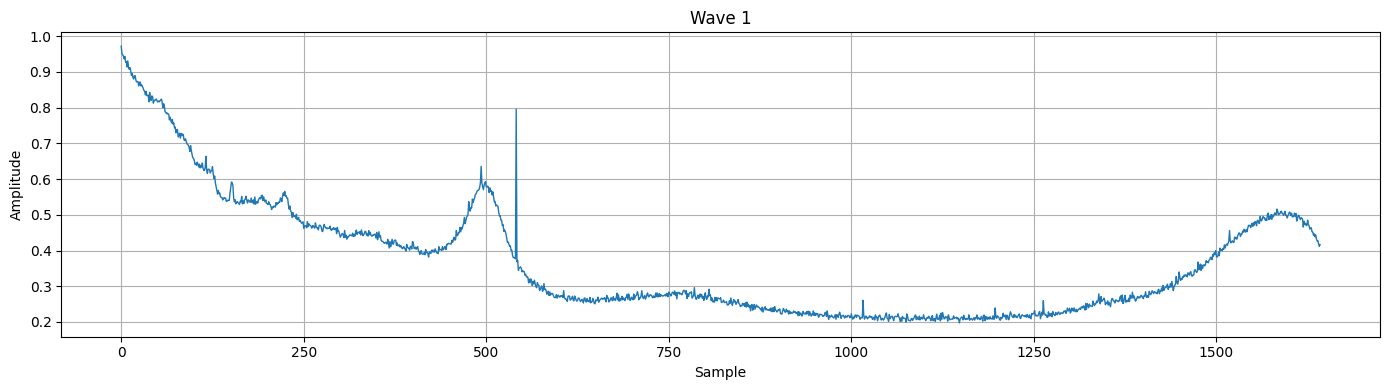

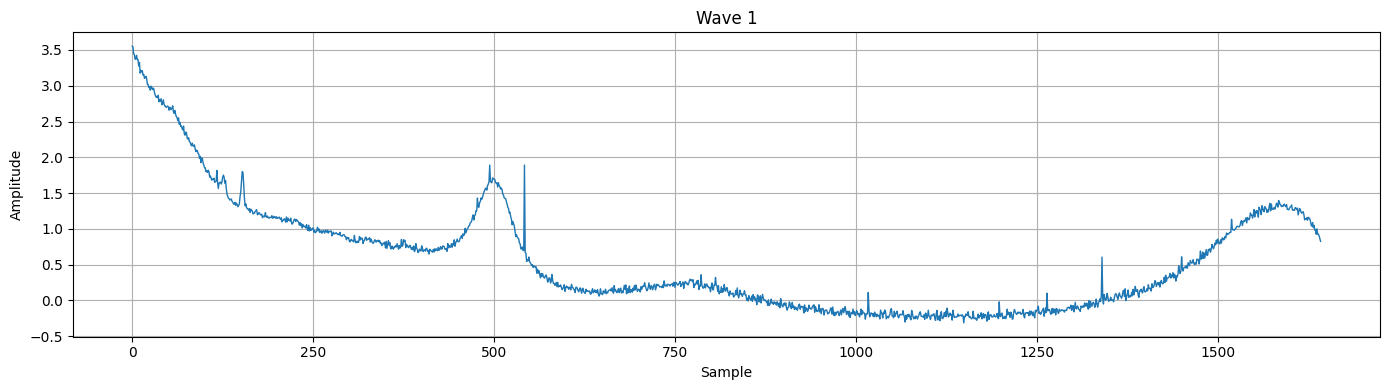

In [258]:
index = get_index(range(96))
show_waves(test_inputs[index].reshape(1, 1643))
show_waves(test_ds[index][0])

In [271]:
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32)

In [283]:
all_preds = []
all_targets = []
model.eval()

for i, t, w in eval_dl:
    #i = data["spectra"].cuda()
    i = i.cuda()
    with torch.inference_mode():
        preds = model(i)
    
    all_preds.append(cuda_to_np(preds))
    all_targets.append(t.numpy())

In [284]:
preds = np.concatenate(all_preds)
targets = np.concatenate(all_targets)
preds.shape, targets.shape

((452, 3), (452, 3))

In [285]:
r2_score(targets, preds)

0.9306592669312265

In [ ]:
mus = targets_mean_std[1][1:][0]
sigmas = targets_mean_std[1][1:][1]

for i in range(3):
    preds[:, i] = reverse_zscore(preds[:, i], mus[i].numpy(), sigmas[i].numpy())
preds

In [307]:
def get_ckpt_paths(keyword):
    output_dir = "/kaggle/working"
    output_files = sorted(os.listdir(output_dir))

    ckpt_paths = []
    for f in output_files:
        if keyword in f and "csv" not in f:
            ckpt_path = os.path.join(output_dir, f)
            ckpt_paths.append(ckpt_path)
            ckpt = torch.load(ckpt_path, weights_only=False)
            print(ckpt_path)#, ckpt["epoch"], ckpt["score"])
            
    return ckpt_paths

ckpt_paths = get_ckpt_paths("pretrain")

/kaggle/working/paper.pretrain.avg.pt
/kaggle/working/paper.pretrain.fold.0.pt
/kaggle/working/paper.pretrain.fold.1.pt
/kaggle/working/paper.pretrain.fold.2.pt
/kaggle/working/paper.pretrain.fold.3.pt
/kaggle/working/paper.pretrain.fold.4.pt


In [291]:
state_dicts = []
for cp in ckpt_paths:
    ckpt = get_ckpt(cp)
    state_dicts.append(ckpt["state_dict"])
len(state_dicts)

5

In [ ]:
import torch
from collections import OrderedDict

def average_state_dicts(state_dict_list):
    """
    Average the weights of several compatible PyTorch state_dicts.

    Parameters
    ----------
    state_dict_list : list[dict]
        List of state_dicts (e.g. from torch.load).
        All must have identical keys and compatible tensor shapes.

    Returns
    -------
    OrderedDict
        New state_dict whose tensors are the arithmetic mean
        of the corresponding tensors in the input state_dicts.
    """
    if not state_dict_list:
        raise ValueError("state_dict_list is empty")

    n = len(state_dict_list)
    # Ensure we don't modify the originals
    avg_sd = OrderedDict()

    # Iterate over every parameter/buffer key
    for k in state_dict_list[0]:
        # sum across models → float32 to avoid overflow on int types
        avg = sum(sd[k].float() for sd in state_dict_list) / n
        # cast back to original dtype if needed
        avg_sd[k] = avg.to(dtype=state_dict_list[0][k].dtype)

    return avg_sd


state_dicts = []
for cp in ckpt_paths:
    ckpt = get_ckpt(cp)
    state_dicts.append(ckpt["state_dict"])

avg_state_dict = average_state_dicts(state_dicts)
torch.save(avg_state_dict, "paper.pretrain.avg.pt")

['/kaggle/working/paper.pretrain.fold.0.pt',
 '/kaggle/working/paper.pretrain.fold.1.pt',
 '/kaggle/working/paper.pretrain.fold.2.pt',
 '/kaggle/working/paper.pretrain.fold.3.pt',
 '/kaggle/working/paper.pretrain.fold.4.pt']